## Model training using fast.ai
Help from [this notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb)

Test notebook to try and run fast.ai on a small dataset we already collected

### Library import

In [2]:
# Python
import numpy as np
import os
from shutil import copyfile, copy2
from string import digits
from sys import platform

# fast.ai
from fastai.vision import *
import torchvision.models as models  # <<<< important to import because fastai does not ahve all of them

In [2]:
# Classes considered
classes = ['bowl', 'cup', 'cutlery', 'plate']
root_path = '/Users/alteste/Repos/ComputerVisionBestPractices/image_classification/data/'
folder_name = 'imgs_recycling'
imgs_path = root_path + folder_name
fn_paths = ["{}/{}".format(imgs_path, name) for name in classes]
fn_paths

['/Users/alteste/Repos/ComputerVisionBestPractices/image_classification/data/imgs_recycling/bowl',
 '/Users/alteste/Repos/ComputerVisionBestPractices/image_classification/data/imgs_recycling/cup',
 '/Users/alteste/Repos/ComputerVisionBestPractices/image_classification/data/imgs_recycling/cutlery',
 '/Users/alteste/Repos/ComputerVisionBestPractices/image_classification/data/imgs_recycling/plate']

In [3]:
fn_paths[-1].split('/')[-1]

'plate'

In [4]:
# verify_images(path=imgs_path, delete=False, max_size=224, dest='.')

Fast.ai expects the images to be in a file structure similar to:
imgs_recycling/
    train/
      class1/
      class2/
      ...
    test/
      class1/
      class2/
However, our data do not have the train/ and test/ intermediate directories. We then need to generate such subfolders.     

### DO THE FOLLOWING ONLY IF THE FOLDER STRUCTURE IS NOT ALIGNED WITH THAT OF FAST.AI

>>> add condition on whether the folder structure is correct or not

<font color='red'><b> !!! fast.ai functions only work if there are ENOUGH images<br>Each class folder in the training set should contain at least 15 images. The number of images in the valid set can be as small as 1.

In [5]:
def train_valid_split(full_list, percent, random_seed):
    valid_size = int(len(full_list)*percent)
    valid_img_list = np.random.choice(full_list, valid_size)
    return valid_img_list

In [6]:
def copy_into_directory(imgs_list, folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
    for img in imgs_list:
        copy2(img, folder)

In [7]:
new_folder = "/tmp/{}".format(folder_name)

train_folder = "{}/train".format(new_folder)  # On Windows, this points to c/tmp/<folder_name>/train/
valid_folder = "{}/valid".format(new_folder)  # On Windows, this points to c/tmp/<folder_name>/valid/
if not os.path.exists(train_folder):  # See where to put it other than here
    os.mkdir(train_folder)
    os.mkdir(valid_folder)
else:
    print("The train/ folder already exists")

The train/ folder already exists


In [8]:
random_seed = 456
percent = 0.2
if not os.path.exists(train_folder):  # See where to put it other than here
    for cl in classes:
        class_folder = "{}/{}".format(imgs_path, cl)
        all_images = os.listdir(class_folder)
        all_images = ["{}/{}".format(class_folder, img) for img in all_images]
        valid_images = train_valid_split(all_images, percent, random_seed)
        train_images = list(set(all_images).difference(set(valid_images)))
        print("{0}:\n --> Train: {1}/{3} images\n --> Valid: {2}/{3} images"
              .format(cl, len(train_images), len(valid_images), len(all_images)))

        class_train_folder = "{}/{}".format(train_folder, cl)
        class_valid_folder = "{}/{}".format(valid_folder, cl)
        copy_into_directory(train_images, class_train_folder)
        copy_into_directory(valid_images, class_valid_folder)
else:
    print("Images have already been re-organized")

Images have already been re-organized


In [9]:
# tfms = get_transforms(do_flip=False)

In [10]:
# data3 = ImageDataBunch.from_folder('C:/Users/alteste/.fastai/data/imgs_recycling')

In [11]:
new_folder

'/tmp/imgs_recycling'

In [12]:
# data0 = ImageDataBunch.from_folder('C:/tmp/imgs_recycling')

In [13]:
data1 = ImageDataBunch.from_folder(new_folder) # -- Only works when there are >= 15 images per folder

In [14]:
type(data1)

fastai.vision.data.ImageDataBunch

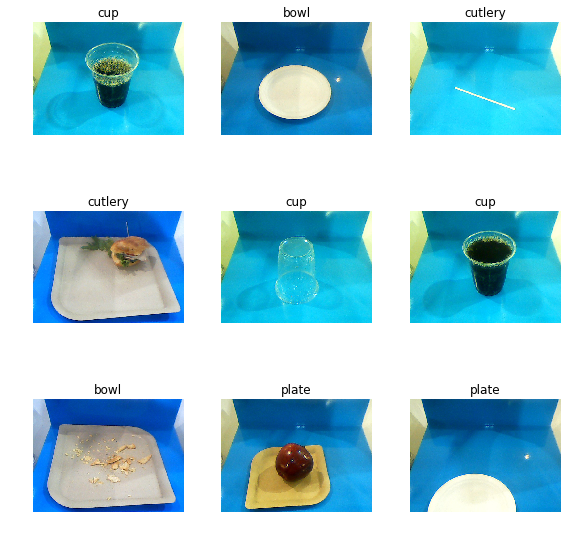

In [15]:
data1.show_batch(rows=3, figsize=(8,8))

In [16]:
data2 = ImageDataBunch.from_folder(new_folder, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [17]:
type(data2)

fastai.vision.data.ImageDataBunch

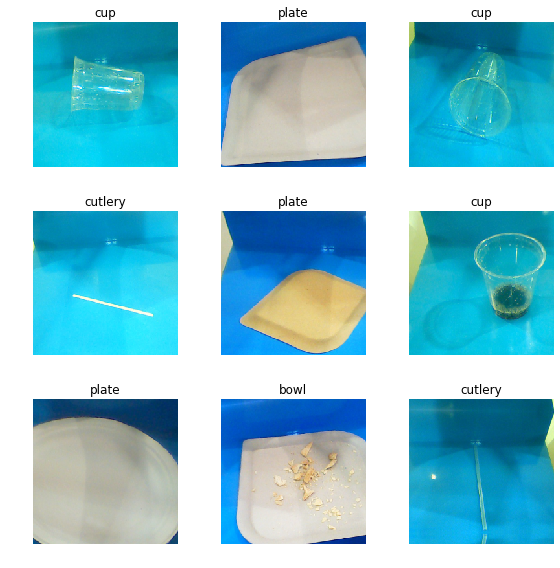

In [18]:
data2.show_batch(rows=3, figsize=(8,8))

In [19]:
data2.classes

['bowl', 'cup', 'cutlery', 'plate']

In [20]:
print("Training dataset: {} samples\nTesting dataset: {} samples"
      .format(len(data2.train_ds.x), len(data2.valid_ds.x)))

Training dataset: 67 samples
Testing dataset: 8 samples


In [21]:
# learn = create_cnn(data2, models.resnet34, metrics=accuracy)  - hangs and never completes on Windows

In [22]:
# learn.fit_one_cycle(1)

In [23]:
def _default_split(m:nn.Module): return (m[1],)
# Split a resnet style model
def _resnet_split(m:nn.Module): return (m[0][6],m[1])
# Split squeezenet model on maxpool layers
def _squeezenet_split(m:nn.Module): return (m[0][0][5], m[0][0][8], m[1])
def _densenet_split(m:nn.Module): return (m[0][0][7],m[1])
def _vgg_split(m:nn.Module): return (m[0][0][22],m[1])
def _alexnet_split(m:nn.Module): return (m[0][0][6],m[1])
def appropriate_nbr_features():  # AT
    nbr_features_dict = {}
    
    nbr_features_dict['alexnet'] = 512
    
    nbr_features_dict['vgg16'] = nbr_features_dict['vgg19'] = nbr_features_dict['vgg16_bn'] = nbr_features_dict['vgg19_bn'] \
    = nbr_features_dict['resnet18'] = nbr_features_dict['resnet34'] \
    = nbr_features_dict['squeezenet1_0'] = nbr_features_dict['squeezenet1_1'] = 1024
    
    nbr_features_dict['resnet50'] = nbr_features_dict['resnet101'] = nbr_features_dict['resnet152'] = 4096

    nbr_features_dict['densenet121'] = 32

    nbr_features_dict['densenet169'] = nbr_features_dict['densenet201'] = 64

    return nbr_features_dict

global number_features  # AT
number_features = appropriate_nbr_features()  # AT

def custom_create_cnn(data:DataBunch, arch:Callable,   # AT (removed num_features)
                  cut:Union[int,Callable]=None, pretrained:bool=True, 
                  lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                  custom_head:Optional[nn.Module]=None, 
                  split_on:Optional[SplitFuncOrIdxList]=None,
                  bn_final:bool=False, **learn_kwargs:Any)->Learner:
    
    model_name = arch.__name__  # AT
    if model_name not in number_features:  # AT
        raise Exception("{} is currently not supported. Please use any of: {}"
                        .format(model_name, list(number_features.keys())))
    
    num_features = number_features[model_name]  # AT
    body = create_body(arch, pretrained, cut)
    head = custom_head or create_head(num_features, data.c, lin_ftrs, ps=ps, bn_final=bn_final)
    model = nn.Sequential(body, head)
    learn = Learner(data, model, **learn_kwargs)

    # extraction of model name  # AT
    needed_split = "_{}_split".format(model_name)
    # removal of potential digits (e.g. as in vgg16 or resnet50)  # AT
    remove_digits = str.maketrans('', '', digits)
    needed_split = needed_split.translate(remove_digits).replace('__','_').replace('_bn', '')

    print("Model *{}* is using {} features".format(model_name, num_features))  # AT

    learn.split(ifnone(split_on, eval(needed_split)))  # AT (replaced by eval(needed_split))

    if pretrained: learn.freeze()
    apply_init(model[1], nn.init.kaiming_normal_)
    return learn
# Work around to prevent create_cnn from hanging, if using Windows
# Found here: https://forums.fast.ai/t/lesson-1-notebook-stuck-in-create-cnn/37486/5
# where num_features=1024 for resnet34, 4096 for resnet50 and 1024 for resnet18

# Source code here: https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L67
# Info on number of features --> need to be multiplied by 2

In [24]:
# %%time
# learn = my_create_cnn(data2, models.resnet34, 1024, metrics=accuracy)
# learn = my_create_cnn(data2, models.alexnet, 512, metrics=accuracy)

# learn = my_create_cnn(data2, models.alexnet, <some number>, metrics=accuracy)
# Used this to find out the proper number of features to consider
# The error message indicates which value to use

In [25]:
# %%time
# learn.fit_one_cycle(1)  # This can take a few minutes

In [26]:
# import torchvision.models as models  # <<<< important to import because fastai does not have all of them
# learn = my_create_cnn(data2, models.densenet121, 48, metrics=accuracy) -- never completes
# learn = my_create_cnn(data2, models.vgg16_bn, 1024, metrics=accuracy)
# learn = custom_create_cnn(data2, models.vgg16_bn, metrics=accuracy)

In [27]:
mdl_object = models.alexnet # or other model

if platform == 'win32':
    learn = custom_create_cnn(data2, mdl_object, metrics=accuracy)
else:
    learn = create_cnn(data2, mdl_object, metrics=accuracy)

Model *alexnet* is using 512 features


In [28]:
learn.fit_one_cycle(5)  # This can take a few minutes  -- 3 epochs --> 75% accuracy with alexnet --> becomes 87.5% with 5 epochs

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

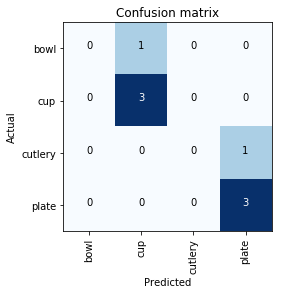

In [30]:
interp.plot_confusion_matrix()

In [162]:
dir(learn.recorder)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_learn',
 '_order',
 'add_metric_names',
 'add_metrics',
 'cb_name',
 'exclude',
 'format_stats',
 'get_state',
 'learn',
 'losses',
 'lrs',
 'metrics',
 'moms',
 'names',
 'nb_batches',
 'no_val',
 'not_min',
 'on_backward_begin',
 'on_backward_end',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_loss_begin',
 'on_step_end',
 'on_train_begin',
 'on_train_end',
 'opt',
 'pbar',
 'plot',
 'plot_losses',
 'plot_lr',
 'plot_metrics',
 'silent',
 'train_dl',
 'val_losses']

In [170]:
learn.recorder.nb_batches

[1, 1, 1, 1, 1]

In [169]:
# learn.recorder.plot()  # --> ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

cutlery


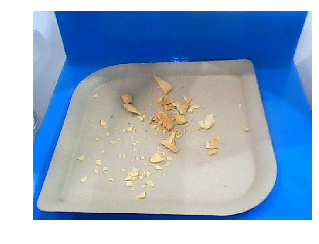

In [31]:
dir(data2)
# data2.valid_ds
# print(data2.train_ds.x)
# print(data2.train_ds.y)
# print(type(data2.train_ds.x))
# print(len(data2.train_ds.x))
# len(data2.train_ds)
data2.train_ds.x[35].show(figsize=(5,5))
print(data2.train_ds.y[35])

cup


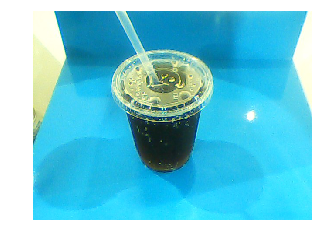

In [32]:
data2.valid_ds.x[3].show(figsize=(5,5))
print(data2.valid_ds.y[3])

In [153]:
data2.train_ds.x

ImageItemList (67 items)
Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640)
Path: \tmp\imgs_recycling

In [132]:
# dir(learn)

# !!!! .export and load_learner() only exist on fastai >= 1.0.40 -- if user has an older version that this, run:
# conda install spacy -c conda-forge
# conda install fastai=1.0.41 -c fastai -c conda-forge 

In [48]:
# learn.save(new_folder+'/export.pkl')
learn.export(new_folder+'/export.pkl')
# by default, load_learner expects a model named "export.pkl" to exist in the current working directory
# if we want to save the model somehwre else, we need to provide the path, but still keep the name of "export.pkl"

# We can actually call the file what we want, but need to use the following: 
# loaded_learner = load_learner(path='/my/path',fname='name.pkl')
# https://forums.fast.ai/t/about-predicting-on-cpu/36376/8

In [49]:
loaded_learner = load_learner(new_folder)

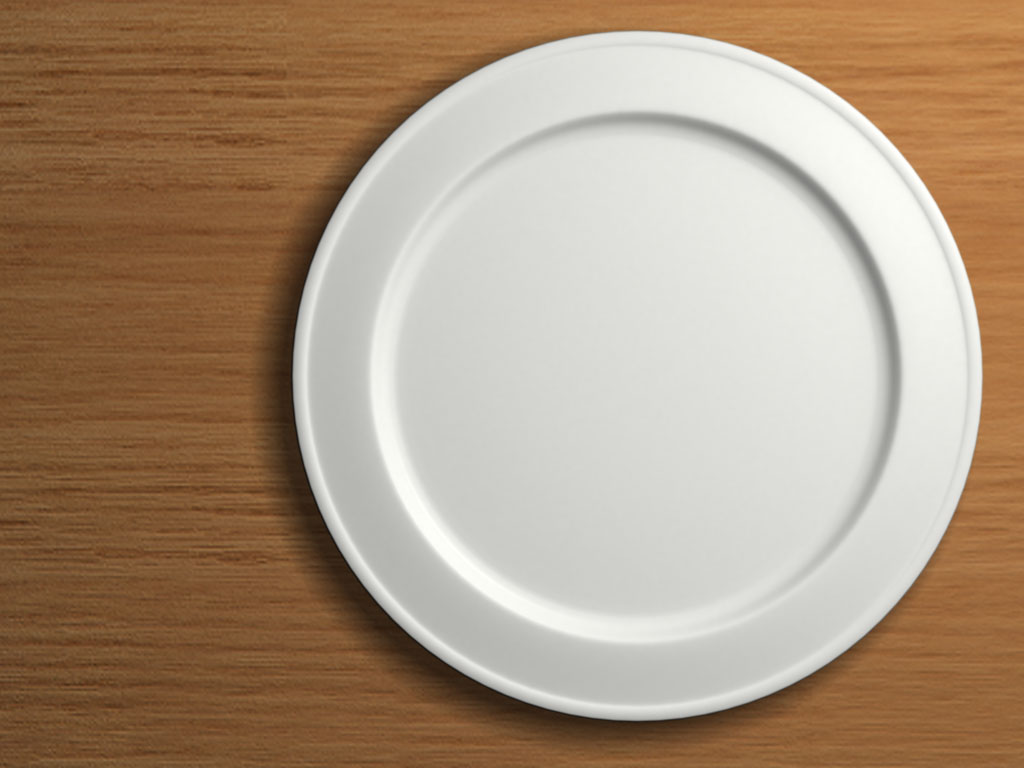

In [137]:
img1 = open_image(new_folder+'/never_seen_images/bing_plate_white.jpg')
img1

In [138]:
img1.shape  # tested on purpose on an image > 224

torch.Size([3, 768, 1024])

In [139]:
pred_class,pred_idx,outputs = loaded_learner.predict(img1)

In [140]:
pred_class

Category plate

In [93]:
print(pred_class,pred_idx,outputs)

plate tensor(3) tensor([0.0909, 0.0807, 0.0306, 0.7977])


In [94]:
# dir(img)

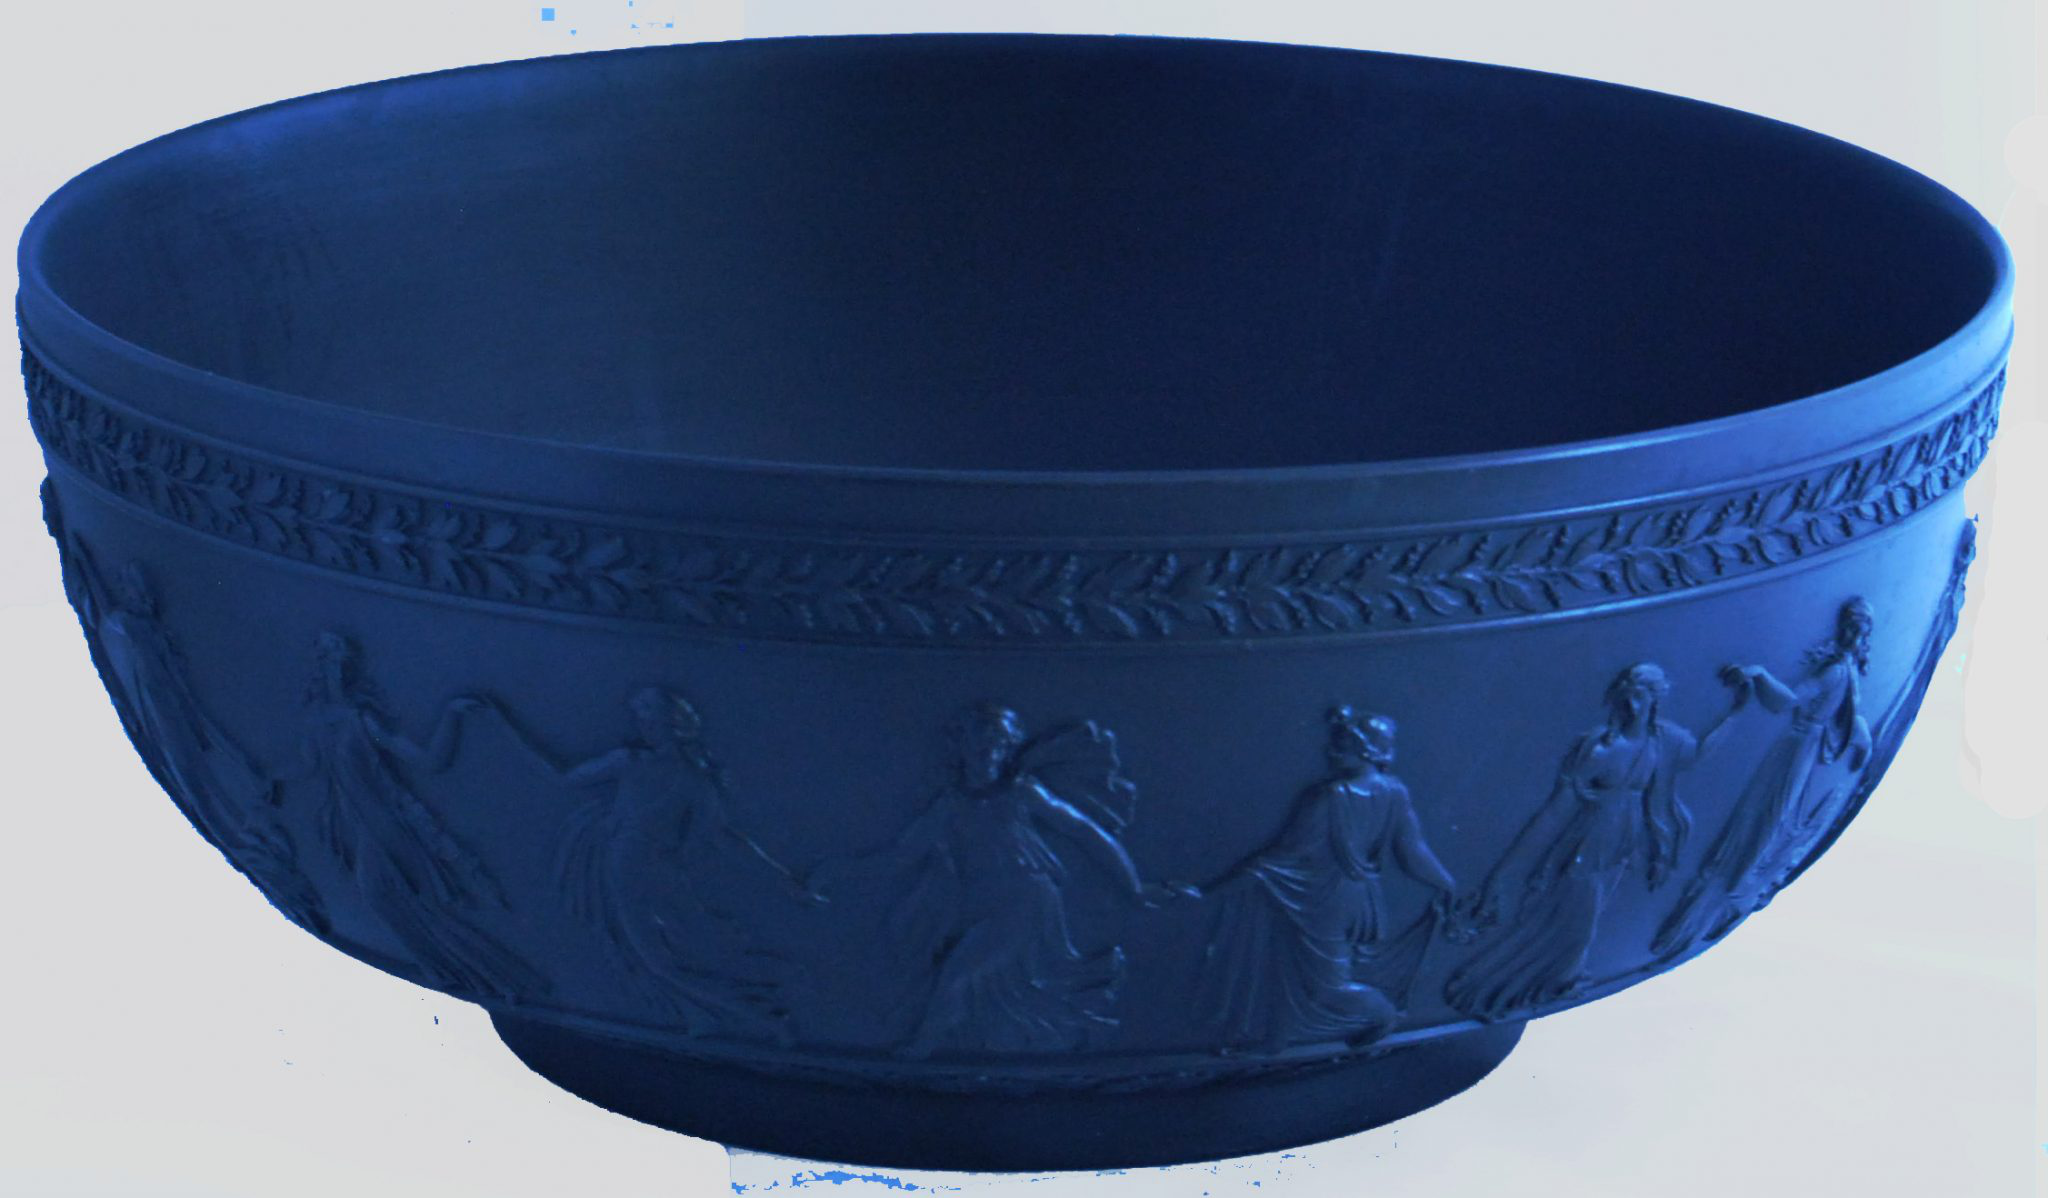

In [141]:
img2 = open_image(new_folder+'/never_seen_images/black-bowl-wedgwood.jpg')
img2

In [142]:
img2.shape

torch.Size([3, 1198, 2048])

In [143]:
pred_class,pred_idx,outputs = loaded_learner.predict(img2)

In [144]:
print(pred_class,pred_idx,outputs)

bowl tensor(0) tensor([0.3825, 0.1722, 0.0916, 0.3536])


In [133]:
dir(pred_class)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_tfms',
 'data',
 'obj',
 'show']

In [136]:
pred_class.obj

'bowl'

In [121]:
outputs.data.numpy()
# Help from: https://discuss.pytorch.org/t/get-value-out-of-torch-cuda-float-tensor/2539/8

array([0.382532, 0.172195, 0.091633, 0.35364 ], dtype=float32)

In [126]:
def convenience_testing(img_filename):
    img = open_image(new_folder+'/never_seen_images/'+img_filename)
    img.show()
    print(img.shape)
    pred_class,pred_idx,outputs = loaded_learner.predict(img)
    outputs = [round(x*100., 2) for x in outputs.data.numpy()]
    print("Class name: {}\nClass index: {}\nProbabilies:\n --> bowl: {}%\n --> cup: {}%\n --> cutlery: {}%\n --> plate: {}%"
          .format(pred_class, pred_idx, outputs[0], outputs[1], outputs[2], outputs[3]))    

torch.Size([3, 200, 200])
Class name: plate
Class index: 3
Probabilies:
 --> bowl: 25.1%
 --> cup: 10.02%
 --> cutlery: 11.62%
 --> plate: 53.26%


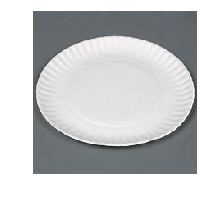

In [131]:
# convenience_testing('black-bowl-wedgwood.jpg')
convenience_testing('bing_paper_plate.jpg')

In [155]:
data2.train_dl.batch_size

64

>>> TEST THE BELOW ONCE THE MODEL IS REGISTERED ON AZURE

In [ ]:
%%writefile script.py

import pickle
import json
import numpy as np
from azureml.core.model import Model
from fastai.vision import *
import torchvision.models as models

# def init():
#     global model
#     # note here "best_model" is the name of the model registered under the workspace
#     # this call should return the path to the model.pkl file on the local disk.
#     model_path = Model.get_model_path(model_name='best_model')
#     # deserialize the model file back into a sklearn model
#     model = joblib.load(model_path)


# # note you can pass in multiple rows for scoring
# def run(raw_data):
#     try:
#         data = json.loads(raw_data)['data']
#         data = np.array(data)
#         result = model.predict(data)

#         # you can return any data type as long as it is JSON-serializable
#         return result.tolist()
#     except Exception as e:
#         result = str(e)
#         return result

    
def init():
    global model
    model_path = Model.get_model_path(model_name='export')  # This model must be registered under the workspace
    model = load_learner(model_path)


# note you can pass in multiple rows for scoring  <<< SEE IF THAT WORKS HERE
def run(image_filename):
    if not isinstance(image_filename, list):
        image_filename = [image_filename]
    result = []
    for img_fname in image_filename:
        try:
            data = open_image(image_filename)
            pred_class, pred_idx, outputs = model.predict(data)
            result.append(pred_class)
            # you can return any data type as long as it is JSON-serializable
#           return result.tolist()  
        except Exception as e:
            result.append(str(e))
#           return result
                
    return result

In [ ]:
learn.export(new_folder+'/test_model.pkl')

In [ ]:
loaded_learner = load_learner(new_folder+'/test_model.pkl')

In [ ]:
>>> NEXT -- USE ONE OF THE SELECTED DATSETS

## Notes - Appendix

In [ ]:
# Reference: https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
Alexnet = 512

# Reference: https://arxiv.org/pdf/1409.1556.pdf
VGG11 and VGG11_bn= # likely 1024 # 22 may not work here, not part of fastai code (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L67)
VGG13 and VGG13_bn = # likely 1024 # same as above
# VGG11 and VGG13 not referenced here: https://github.com/fastai/fastai/blob/master/fastai/vision/learner.p
# --> not available in custom create_cnn function + returns an error in:
# def _vgg_split(m:nn.Module): return (m[0][0][22],m[1])--> IndexError: index 22 is out of range
VGG16 and VGG16_bn = 1024
VGG19 and VGG19_bn = 1024

# Reference: https://arxiv.org/pdf/1512.03385.pdf
Resnet18 = 1024 # cf. Table 1, page 5, # params in last conv layer x 2
Resnet34 = 1024
Resnet50 = 4096
Resnet101 = 4096
Resnet152 = 4096

# Reference: https://arxiv.org/pdf/1602.07360.pdf
Squeezenet1_0 = 1024 # cf Table 1, page 6, 512 x 2
Squeezenet1_1 = 1024 # same as above

# Reference: https://arxiv.org/pdf/1608.06993.pdf
Densenet121 = # likely 32 -- from Table 1, page 4, 16 x 2
Densenet161 = # likey 32 or 64  # Densenets are very memory hungry for both the parameters and connections --> very long to train
Densenet169 = # likely 64
Densenet201 = # likely 64
Inceptionv3 = # not found in fastai create_cnn
# Values obtained from error messgae returned from <conda_environment>\lib\site-packages\torch\nn\functional.py
# https://pytorch.org/docs/stable/torchvision/models.html

# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Models get stored in /Users/alteste/.torch/models

In [ ]:
print(platform)

In [ ]:
list(number_features.keys())

In [1]:
from utils import image2json

In [3]:
current_directory = os.getcwd()

In [4]:
images_fname_list = ['msft-plastic-bowl20170725152154282.jpg', 'msft-paper-plate20170725132850611.jpg']
test_samples, all_images = image2json(images_fname_list, current_directory)

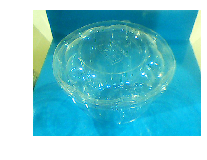

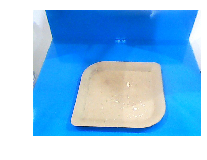

In [5]:
for im in all_images:
    im.show()

In [8]:
len(test_samples)

34609124

In [9]:
all_data = json.loads(test_samples)['data']

In [10]:
type(all_data)

list

In [16]:
len(all_data[0][0][0])

640